In [1]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

In [72]:
import random
indices = np.arange(20)
print(indices)
random.shuffle(indices)
print(indices)
print(np.random.permutation(indices))
print(torch.randperm(20))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 6  8  0  1 12  7 15  3  2 11 16 13 14 18 10  4 19  9 17  5]
[ 8  5 16 13  7  2 17  6  1 11 10 15  3 12 19 14  9  0  4 18]
tensor([10,  0, 16, 19, 12,  4,  7, 11,  1,  9,  8, 15, 13,  2, 18, 14, 17,  6,
         3,  5])


In [62]:
np.random.permutation(10)

array([0, 4, 1, 3, 8, 6, 7, 5, 9, 2])

In [19]:
torch.randperm(10)

tensor([0, 2, 6, 7, 8, 1, 5, 3, 4, 9])

In [13]:
np.random.shuffle(10)

TypeError: object of type 'int' has no len()

## 2. Inference: Marginal Distribution

Suppose a model generate a joint probability distribution $p(y,z|x)$ over latent variable $z$ and return $y$. Then the question is how to compute the marginal probability of an output $p(y|x)$ or draw sample from marginal distribution.

**Inference**  is the problem of constructing this marginal distribution given an arbitrary boolean constraint so that we can perform the above computations.

To motivate the rest of this tutorial, let’s first build a generative model for a simple physical problem so that we can use Pyro’s inference machinery to solve it.

In pyro the marginalization is implemented on **pyro.infer.Marginal**

### Example

Suppose we are trying to figure out how much power an appliance cunsume, but the meter we’re using is unreliable and gives slightly different answers every time we monitor the same appliance. We could try to compensate for this variability by integrating the noisy measurement information with a guess based on some prior knowledge about the appliance, like its material properties. The following model encodes this process:

In [2]:
def monitor(guess):
    # The prior over weight encodes our uncertainty about our guess
    power = pyro.sample("power", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true power
    return pyro.sample("measurement", dist.normal, power, Variable(torch.Tensor([0.75])))

## 2.2 Representing Marginal Distributions
Before using our model to estimate  appliance power consumption let’s  analyzing our model’s behavior.Using importance sampling we can simulate the marginal distribution of measurement values we’d expect to see a priori for a given guess.

To do this using marginalization we need to follow the follwing two steps
- collect a number of monitored execution traces of the model.
- collapse those traces into a histogram over possible return values given a particular set of arguments.

We can use sampling to collect number of monitored execution

In [6]:
#create sampler using the prior as the proposal distribution
posterior = pyro.infer.Importance(monitor, num_samples=100)

#create a guess variable
guess = Variable(torch.Tensor([100]))
#uses posterior to generate a sequence of weighted execution traces given guess
marginal = pyro.infer.Marginal(posterior)
#finally returns a sample drawn from the histogram
print(marginal(guess).data[0])

100.5958251953125


Text(0,0.5,'#')

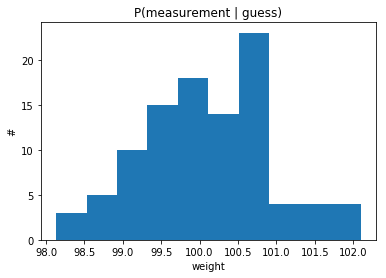

In [8]:
plt.hist([marginal(guess).data[0] for _ in range(100)], )
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")